# Notes on Superhydrophobic Nanopartical Coatings Solar Panel Processing Code and Analysis

The goal of this project put forth by Dr. Amanda Barker at CRREL is to inform the Army of the performace and applicability of commercially-available solar panel coatings. We are looking to study the main effects of these coatings. We suppose that the coatings minimize the effect of ice, dirt, and most importantly snow accumulation during extreme weather events, in turn we hope the panels will perform better and be easier to maintain over their lifetime.

## Methods
This project tested 3 different solar panel coatings. Coating 1 was described as a 'proprietary compound'. Coating 2 is a silicon dioxide nanoparticle-based proprietary substance. Coating 3 is a titanium dioxide nanoparticle-base proprietary substance. Site information such as angle of array, solar irradiance, albedo, global horizontal irradiance, air temperature, panel temperature, daily time-lapse video, and wind velocity were also obtained. 
...


## Time-lapse Processing Code

#### Introduction 
We expect snow cover to be a key predictor in the performance of each panel. To measure snow cover daily time-lapse videos were recorded. In the processing of this data there are some key factors to keep in mind. The time series time step of the data is important, we want to be able to capture the signal that is snow cover while at the same time ensuring that our analysis adequately deals with the possibility of autocorrelation in our data. 

#### Dependencies 
For a majority of this project we will be using python, and more specifically cv2 the python wrapper for OpenCV. 

In [1]:
import numpy as np
import pandas as pd
import os 
from PIL import Image
import cv2 # For Image Processing 
from matplotlib import pyplot as plt
import copy


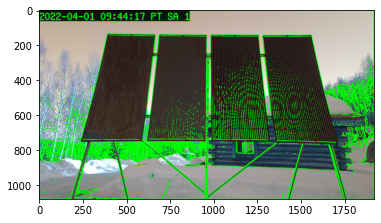

In [2]:

## Preliminary Image Processing Code
path = r'C:\Users\Amanda Barker\Desktop\Stefano\CRREL-Solar-Project\TestTimeLapse' ##Supply Full Path to TimeLapse directory
os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
img = cv2.imread('TestImage2.png') # Reading in the current image
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh)
contours, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # [-2:] indexing takes return value before last (due to OpenCV compatibility issues).
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(image_copy)

<Figure size 432x288 with 0 Axes>

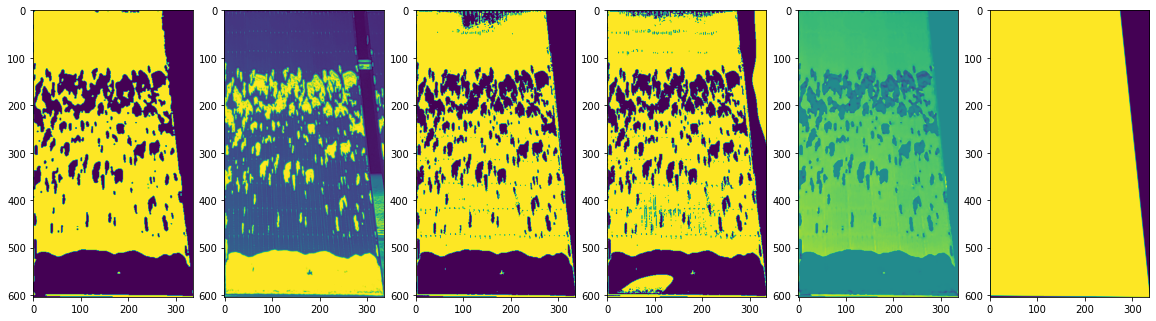

In [8]:
#### Testing For Generating the Image Processing Function
TestSetting = 6
if (TestSetting == 1):
    ## Glare During The DAY
    img = cv2.imread('TestImage3.png')
    pts = np.array([(1245, 151), (1535, 138), (1705, 780), (1343, 777)])
elif (TestSetting == 2):
    ## Snow During the Day
    img = cv2.imread('TestImage4.png')
    pts = np.array([(631, 156), (913, 154), (924, 788), (572, 797)])
elif (TestSetting == 3):
    ## Snow During the Day with weird coating
    img = cv2.imread('TestImage4.png')
    pts = np.array([(944, 159), (1224, 156), (1301, 779), (961, 785)])
elif (TestSetting == 4):
    ## No Snow or glare during the day
    img = cv2.imread('TestImage2.png')
    pts = np.array([(987, 145), (1256, 146), (1316, 744), (991, 743)])
elif (TestSetting == 5):
    ## Snow During the Night 
    img = cv2.imread('TestImage.png')
    pts = np.array([(986, 145), (1258, 145), (1321, 748), (987, 745)])
elif (TestSetting == 6):
    ## No Snow During the Night
    img = cv2.imread('TestImage5.png')
    pts = np.array([(311, 164), (604, 164), (533, 776), (142, 803)])
elif (TestSetting == 7):
    ## Almost Fully Covered Panel in the Day from the old Array
    img = cv2.imread('TestImage6.png')
    pts = np.array([(242, 230), (401, 230), (400, 312), (234, 312)])
elif (TestSetting == 8):
    ## Night Time With a tiny bit of snow
    img = cv2.imread('TestImage.png')
    pts = np.array([(692, 144), (959, 145), (953, 746), (623, 748)])
elif (TestSetting == 9):
    ## Cropped 8 to have a larger section of snow
    img = cv2.imread('TestImage.png')
    pts = np.array([(364, 268), (643, 274), (580, 746), (245, 747)])
    
    
    


    

    
    ## Twilight?
    ## Glare and Snow During the Day






    ## Explore contours for measuring snow cover. 
    ## Seems to work well when the panel has snow. 
    ## Detecting when the panel has snow with contours?
    ## Empty panel during the days has a bunch of lines, 
    ## During the night there are a bunch of dots. Expiriemtn with kernel convolutions to extract these patterns. 
    ## 


## Cropping the bounding rectangle
rect = cv2.boundingRect(pts)
x,y,w,h = rect
cropped = img[y:y+h, x:x+w].copy()

## Converting the crop to gray scale
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

## Testing Contrast 
## cropped = cv2.equalizeHist(cropped)
## This increases the contrast of the image. Use this and TestSetting == 2 to 
## see an example for when We Have SNOW and SUN  

## Generating the Mask
pts = pts - pts.min(axis=0)
mask = np.zeros(cropped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## Removing everything outside the Mask with bitwise operation
dst = cv2.bitwise_and(cropped, cropped, mask=mask)

## Testing Different Backgounds
testBackground = 1
if testBackground == 1:
    bg = np.ones_like(cropped, np.uint8)*127
    cv2.bitwise_not(bg,bg, mask=mask)
    dst = bg+ dst

############## Use Mask to threshold and pull the snow cover data
AdaptiveMeanThresh = cv2.adaptiveThreshold(dst, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 199, 5)

AdaptiveGaussThresh = cv2.adaptiveThreshold(dst, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 199, 5)

# Otsu's thresholding after Gaussian filtering
##### Testing Blurs
#dst = cv2.GaussianBlur(dst,(5,5),0)
dst = cv2.medianBlur(dst, ksize=5) ### THIS IS VERY IMPORTANT IT DEALS WITH THE LINES AND DOTS ON THE PANELS
cv2.imwrite('testGaussblur.png', dst)
### Filters out horizontal Lines
# linek = np.zeros((11,11),dtype=np.uint8)
# linek[5,...]=1
# x=cv2.morphologyEx(dst, cv2.MORPH_OPEN, linek ,iterations=1)
# dst-=x

ret3,th3 = cv2.threshold(dst,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#linkek =[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#         [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
#         [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
#         [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
#         [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#         [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]
#
#linkek = np.array(linkek)
#x=cv2.morphologyEx(th3, cv2.MORPH_OPEN, linek ,iterations=1)
#th3-=x




cv2.imwrite('testAdaptiveMean.png', AdaptiveMeanThresh)
cv2.imwrite('testAdaptiveGauss.png', AdaptiveGaussThresh)
cv2.imwrite('testGaussblurGlobalOtsu1.png', th3) ## CONTINUE TESTING THIS METHOD



#Plotting The Figures In the Notebook
plt.figure()
f, Multifigure = plt.subplots(1,6, figsize = (20,10)) 

Multifigure[0].imshow(th3)
Multifigure[1].imshow(cropped)
Multifigure[2].imshow(AdaptiveMeanThresh)
Multifigure[3].imshow(AdaptiveGaussThresh)
Multifigure[4].imshow(dst)
Multifigure[5].imshow(mask)






In [ ]:
# Gui and Coordinate extaction code
def click_event(event, x, y, flags, params):
	global MaskCoordinates
	
    # Listening for Left Click
	if event == cv2.EVENT_LBUTTONDOWN:

        # Print and Append Coordinates
		print(x, ' ', y)
		MaskCoordinates.append((x, y))

        # Display Coordinates 
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img,'+', (x,y), font, .2, (255,164,0))
		cv2.imshow('image', img)

	# Listening for Right Click	
	if event==cv2.EVENT_RBUTTONDOWN:

        # Print and Append Coordinates
		print(x, ' ', y)
		MaskCoordinates.append((x, y))


		# Display Coordinates 
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img,'+', (x,y), font, .2, (255,164,0))
		cv2.imshow('image', img)


# Driver function for MaskCoordinates array generation
# This function will take the initial frame of ever timelapse video
def generateMasks(img):
	# Displaying the image
	cv2.imshow('image', img)

    # Running MouseClick Callback
	cv2.setMouseCallback('image', click_event)

	# Exiting when a key is pressed
	cv2.waitKey(0)

	# Closing the Image Window
	cv2.destroyAllWindows()

In [4]:
## Driver Code for coordinate extraction
MaskCoordinates = []
img = cv2.imread('TestImage.png')
generateMasks(img)
print(MaskCoordinates)


NameError: name 'generateMasks' is not defined

In [54]:
def FindOtsuThresh(orig, mask):
    ### Generating the greyscale value histogram
    freq = np.zeros(256)
    for i in range(len(orig)):
        for j in range(len(orig[0])):
            if (mask[i,j] != 0):
                freq[orig[i,j]] += 1    

    ### Normalizing to get probability dist. 
    total = sum(freq)
    prob = freq/total

    ## Applying Otsu's binarization algorithm to find the threshold which maximizes inter-class variance, 
    inter_variance = np.zeros(255)
    for i in range(1,256):
        w_0 = sum(prob[0:i-1]) 
        w_1 = sum(prob[i:255])
        if (w_0 == 0 or w_1 == 0):
            inter_variance[i-1] = 0
        else:
            mu_0 = sum(range(1,256)[1:i-1]*prob[1:i-1])/w_0
            mu_1 = sum(range(1,256)[i:255]*prob[i:255])/w_1
            inter_variance[i-1] = w_0*w_1*(mu_0 - mu_1)**2

    ## Pulling threshold where inter_variance is maximized
    Otsu_Thresh = np.argmax(inter_variance)
    return Otsu_Thresh


    

In [62]:
contrastTest = cv2.equalizeHist(dst)
OtsuThresh = FindOtsuThresh(contrastTest, mask)

In [63]:
print(OtsuThresh, ret3)

131 32.0


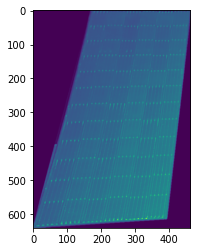

In [65]:
ret, thresh = cv2.threshold(dst,0,255, 131)
plt.imshow(thresh)


In [131]:
mask[1,1]

0

In [5]:
(len(np.extract(mask > 0, th3)) - np.count_nonzero(np.extract(mask > 0, th3)))/len(np.extract(mask > 0, th3)) ## Code For Computing Snow Cover

0.005925975339937516

In [6]:
(np.count_nonzero(np.extract(mask > 0, th3)))/len(np.extract(mask > 0, th3)) ## Area exposed

0.9940740246600624